## Forward Kinematics - Positions

Let's try to implement a robot with two revolute joints. We will say that the first and second link have lengths l<sub>1</sub> and l<sub>2</sub> respectivelly. Given the joint positions $\theta$ = ($\theta$<sub>1</sub>, $\theta$<sub>2</sub>), let's calculate the 2d positions of the first and second link.

In [311]:
import math

def forward_kinematics(l1=1,l2=1,theta=(0,0)):
    x1 = math.cos(theta[0])*l1
    y1= math.sin(theta[0])*l1
    
    x2 = x1 + math.cos(theta[1]+theta[0])*l2 
    y2 = y1 + math.sin(theta[1]+theta[0])*l2 
    
    return((x1,y1),(x2,y2))
    

x1 and x2 are very intuitive to calculate based on trigonometry. x2 and y2 are a bit trickier: we add theta[1] and theta[0] together inside the cosine and sine because we want the second link to pivot relative to the first link, so we add the rotations together.

Note that this function is not linear in $\theta$ (since it has to go through a cos and sin function), although it is linear in cos($\theta$) and sin($\theta$)

## Robot visualization and simulation

Now, let's right some code to visualize the robot

In [312]:
import matplotlib.pyplot as plt

def visualize_robot(l1=1,l2=1,theta=(0,0),show=True,print_link=False,colors=("red","blue")):
    link1, link2 = forward_kinematics(l1,l2,theta)
    if print_link:
        print(f"link1: {link1}, link2:{link2}")
    plt.plot(*zip((0,0),link1), marker='o',color=colors[0])
    plt.plot(*zip(link1,link2), marker='o',color=colors[1])
    
    plt.xlim([-(l1+l2+1), l1+l2+1])
    plt.ylim([-(l1+l2+1), l1+l2+1])
    if show:
        plt.show()

link1: (1.0, 0.0), link2:(1.0, 1.0)


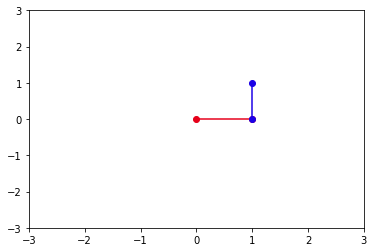

In [313]:
visualize_robot(theta=(0,math.pi/2), print_link=True, colors=((0.9,0,0.1),(0.1,0,0.9)))

**QUIZ**: Can you find 5 different joint configurations where the robot is fully reached out? What similarities do you notice between the joint configuration?

**QUIZ**: Can you find a joint configuration to make the tip of the robot touch the origin of the robot? Find a few joint configurations that do, and look at what similarities are between them.

## Forward Kinematics - Velocities

So, if f=forward_kinematics, and $\tau$ is a vector describing the task space (2D end-effector position in this case, which is where the tip of l<sub>2</sub> is, which is just (x<sub>2</sub>,y<sub>2</sub>)), then (x<sub>2</sub>,y<sub>2</sub>) = $\tau$ = f($\theta$). Note that we are ignoring (x<sub>1</sub>,y<sub>1</sub>), since we are just interested in manipulating the end effector.

So, let the derivative of $\tau$ with respect to time $t$ be $\dot{\tau}$, which represents the 2D velocity of the end-effector. This is equal to taking the derivative of f with respect to $t$, by chain rules gives $\dot{\tau}$ = J($\theta$)*$\dot{\theta}$, where J($\theta$) is the Jacobian (matrix of partial derivatives of f with respect to $\theta$), and $\dot{\theta}$ is the joint velocity. Note that J is a 2x2 matrix and is a function of the joint positions $\theta$. If we take the partial derivatives of the forward_kinematics function, we get:

$$\nabla f = J = 
\left(\begin{array}{cc} 
\frac{df_{1}}{d\theta_{1}} & \frac{df_{1}}{d\theta_{2}}\\
\frac{df_{2}}{d\theta_{1}} & \frac{df_{2}}{d\theta_{2}}
\end{array}\right)
$$

$$= 
\left(\begin{array}{cc} 
-sin(\theta_{0})l_{1} - sin(\theta_1 + \theta_0)l_{2}  & - sin(\theta_1 + \theta_0)l_{2}\\
cos(\theta_{0})l_{1} + cos(\theta_1 + \theta_0)l_{2}  & cos(\theta_1 + \theta_0)l_{2}\\
\end{array}\right)
$$

Let's write a function that gives us this matrix

In [314]:
import numpy as np

def _J(theta=[0,0],l1=1,l2=1):
    dx_t0 = -math.sin(theta[0])*l1 - math.sin(theta[0]+theta[1])*l2
    dx_t1 = - math.sin(theta[0]+theta[1])*l2
    dy_t0 = math.cos(theta[0])*l1 + math.cos(theta[0] + theta[1])*l2
    dy_t1 = math.cos(theta[0] + theta[1])*l2
    return(np.array([[dx_t0, dx_t1],[dy_t0, dy_t1]]))

In [315]:
J = _J(theta=(0.5,0.5))
print(J)

[[-1.32089652 -0.84147098]
 [ 1.41788487  0.54030231]]


Unlike the forward_kinematics function, the Jacobian is a linear map (by definition, it's just a matrix of first-order partial derivatives), except instead of mapping joint configurations to end-effector poses, it maps joint velocities to end-effector velocities. That is neat! But also remember that each joint configuration has its own Jacobian, and the mapping from joint configurations to Jacobians is not linear. Kinda weird but pretty cool!

## Linear approximation of end-effector delta via Jacobian

So, now for a give joint configuration $\theta$, we can use the Jacobian to get a linear approximation of how the end effector will move as a function of the joint velocities.

In [316]:
theta = np.array([0,0])
theta_dot = np.array([0.5,0.25])
J = _J(theta=theta)
print(J)
tau_dot = np.matmul(J,theta_dot)
print(tau_dot)

[[-0. -0.]
 [ 2.  1.]]
[0.   1.25]


That's interesting: the velocity for the x component is 0, which means that for small applications of the joint velocity at the current joint position, the x component won't change. Let's check if that's true. First, let's visualize theta. Then, let's slightly change theta based on the joint velocities, and then replot it.

[[-0. -0.]
 [ 2.  1.]]
[0.   1.25]


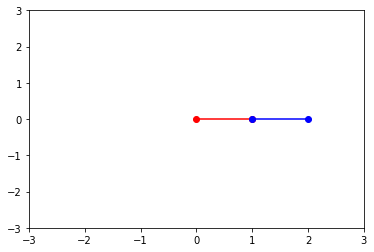

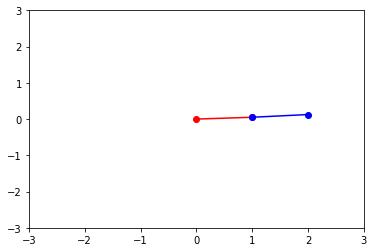

In [317]:
theta = np.array([0,0])
theta_dot = np.array([0.5,0.25])
J = _J(theta=theta)
print(J)
tau_dot = np.matmul(J,theta_dot)
print(tau_dot)

visualize_robot(theta=theta)


delta = 0.1

theta_delta = theta_dot * delta
theta = theta + theta_delta

visualize_robot(theta=theta)

Based on tau_dot, we can predicate how link2 will change between the first plot and the second plot!

## Jacobian Inverse

In many cases, the Jacobian will rank of 2, which means that it is non-singular, and therefore the matrix is invertible.

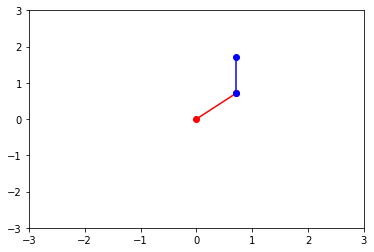

[[-1.70710678e+00 -1.00000000e+00]
 [ 7.07106781e-01  6.12323400e-17]]
Rank of J is 2


In [318]:
import math
theta = (math.pi/4,math.pi/4)
visualize_robot(theta=theta)
J = _J(theta=(theta))
print(J)
print(f"Rank of J is {np.linalg.matrix_rank(J)}")

If the matrix is invertible, we can calculate the joint velocities to realize a specified end-effector velocity.

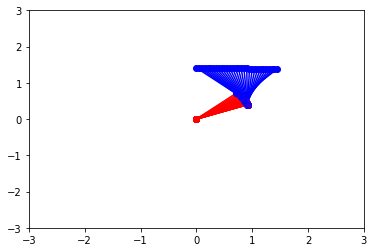

In [319]:
theta = (math.pi/4,math.pi/2)
tau_dot = [1,0]
for _ in range(30):
    visualize_robot(theta=theta,show=False)
    J = _J(theta=(theta))

    J_inv = np.linalg.inv(J)

    theta_dot = np.matmul(J_inv, tau_dot)
    delta = 0.05
    theta = theta + theta_dot * delta

plt.show()


Here we can see we set the end effector velocity to [1,0], which we can use to get the joint velocities that make that possible, as we see from the fact that the robot arm moves the tip of the end effector rightward

## Drawing with the Jacobian!

We can draw use this newfound power to draw shapes too! Polygons are the easiest, but SOMEONE suggested I try to draw a circle! How would we do that? Let's find out!

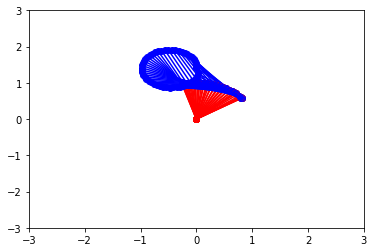

In [320]:
theta = [math.pi/4, math.pi/2]
delta = 0.05
radius = 1.25 #The radius of the circle we intended to draw
#Question: In order to make drawn circle be this radius, should I somehow relate delta to radius?

cur_degree = 0 #this is the current degrees in the circle we are drawing, start at 0
for cur_degree in np.arange(0,2*math.pi,2*math.pi/50):
    visualize_robot(theta=theta,show=False)
    #claculate the tangent to the circle at this degree. The tangent defines how we want the end effector tip to move
    x_dot = -math.sin(cur_degree)*radius
    y_dot = math.cos(cur_degree)*radius
    
    tau_dot = [x_dot,y_dot]
    
    J = _J(theta=(theta))

    J_inv = np.linalg.inv(J)

    theta_dot = np.matmul(J_inv, tau_dot)
    theta = theta + theta_dot * delta
    
plt.show()
    
    

## Singularities

But consider when the robot is at the edge of it's workspace, such that the arm is fully extended

Jacobian is [[-0.49480792 -0.24740396]
 [ 1.93782484  0.96891242]]


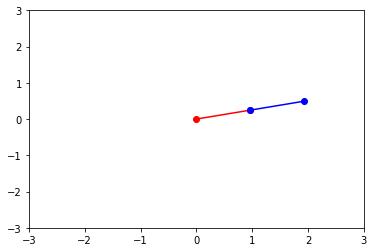

Rank of J is 1


In [321]:
theta = (0.25, 0)
J = _J(theta=theta)
print(f"Jacobian is {J}")
visualize_robot(theta=theta) #See the robot arm is fully extended
print(f"Rank of J is {np.linalg.matrix_rank(J)}")

The matrix is singular when the matrix is not full rank, so we would say there is a singularity at the joint position (0.25, 0). The Jacobian isn't obviously singular by inspection, but we can confirm that the colums are linearly dependent: 


In [322]:
theta = (0.25, 0)
J = _J(theta=theta)
print(J[0,0] / J[0,1])
print(J[1,0] / J[1,1])

2.0
2.0


The column space of the Jacobian represents the vector space of realizable end-effector velocities. When the matrix is singular, we lose a direction that is possible. This is especially obvious if you look at the jacobian of the two-link robot when it is at (0,0)

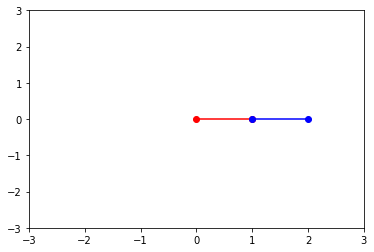

[[-0. -0.]
 [ 2.  1.]]


In [323]:
theta = (0, 0)
visualize_robot(theta=theta)
J = _J(theta=theta)
print(J)

The robot's arm is fully stretched out to the right, so it's impossible for the arm to go further right. As we can see, the column space of the Jacobian is spanned by [0,1], which [1,0] is not a part of. Therefore, locally at this joint configuration, the tip of the end-effector can only move up or down. This makes sense it loses the ability to move further right, but it's interesting it also implies that the robot can't move it's end effector left without first going up or down a bit.

## Jacobian determinent as proxy for distance to singularities

The rank of the Jacobian is very discrete (i.e: the rank is always an integer), but intuitively, how close a joint configuration is to a singularity can be a graded value. For example, consider the two joint configurations:

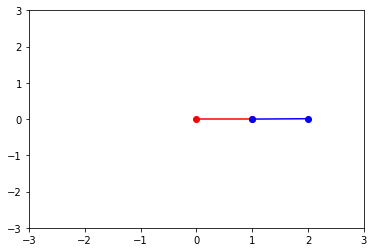

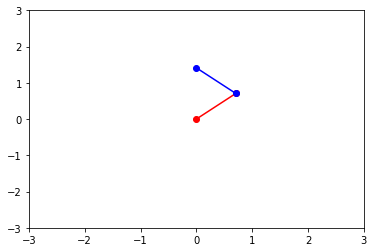

rank of [0, 0.01] is 2
rank of [0.7853981633974483, 1.5707963267948966] is 2


In [324]:
theta_1 = [0,0.01]
theta_2 = [math.pi/4,math.pi/2]

visualize_robot(theta=theta_1)
visualize_robot(theta=theta_2)

J1 = _J(theta_1)
J2 = _J(theta_2)

print(f"rank of {theta_1} is {np.linalg.matrix_rank(J1)}")
print(f"rank of {theta_2} is {np.linalg.matrix_rank(J2)}")

Both of the Jacobians at these two joint configurations is 2, but intuitively theta_1 seems closer to a singularity since it's very close to the edge of the workspace. One way to think about this is to look at the determinent of the Jacobian, which tells us the volume created by the transformation. When a matrix is singular, the determinent is 0, and when we're far away from a singularity, the determinent should be high!

In [325]:
theta_1 = [0,0.01]
theta_2 = [math.pi/4,math.pi/4]

J1 = _J(theta_1)
J2 = _J(theta_2)

print(f"determinent of {theta_1} is {np.linalg.det(J1)}")
print(f"determinent of {theta_2} is {np.linalg.det(J2)}")

determinent of [0, 0.01] is 0.009999833334166668
determinent of [0.7853981633974483, 0.7853981633974483] is 0.7071067811865476


As we can see, the determinent is much higher for theta_2 than theta_1, which is really neat-o!

## Approaching singularities leads to joint velocity sadness

Let's go back to our drawing circle example. If you actually play around with the initial joint configuration of the robot, sometimes you get really weird looking shapes

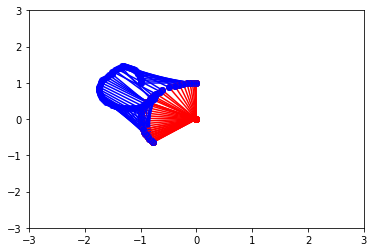

In [326]:
theta = [math.pi/2,math.pi/2]
delta = 0.05
radius = 1.25 #The radius of the circle we intended to draw
#Question: In order to make drawn circle be this radius, should I somehow relate delta to radius?

cur_degree = 0 #this is the current degrees in the circle we are drawing, start at 0
for cur_degree in np.arange(0,2*math.pi,2*math.pi/50):
    visualize_robot(theta=theta,show=False)
    #claculate the tangent to the circle at this degree. The tangent defines how we want the end effector tip to move
    x_dot = -math.sin(cur_degree)*radius
    y_dot = math.cos(cur_degree)*radius
    
    tau_dot = [x_dot,y_dot]
    
    J = _J(theta=(theta))

    J_inv = np.linalg.inv(J)

    theta_dot = np.matmul(J_inv, tau_dot)
    theta = theta + theta_dot * delta
    
plt.show()
    
    

I mean, it KINDA looks like a circle for some part of it, but then it veers off very weirdly. What's going on? Maybe the first thing we can do is graph the determinent of each Jacobian as we progress through drawing the circle to see if we're getting near a singularity.

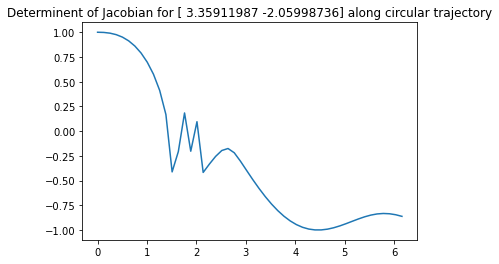

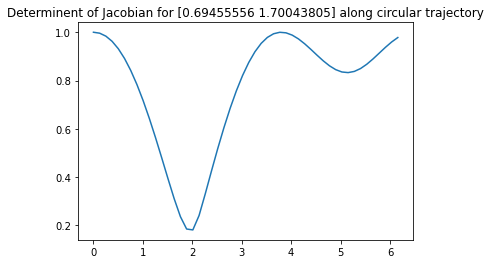

In [327]:
theta_bad = [math.pi/2, math.pi/2]
theta_good = [math.pi/4, math.pi/2]
delta = 0.05
radius = 1.25 #The radius of the circle we intended to draw
#Question: In order to make drawn circle be this radius, should I somehow relate delta to radius?

bad_determinent_list = []
good_determinent_list = []

cur_degree = 0 #this is the current degrees in the circle we are drawing, start at 0
start = cur_degree
end = 2*math.pi
step_size = (end-start)/50
for cur_degree in np.arange(start,end,step_size):
    #visualize_robot(theta=theta,show=False)
    #claculate the tangent to the circle at this degree. The tangent defines how we want the end effector tip to move
    x_dot = -math.sin(cur_degree)*radius
    y_dot = math.cos(cur_degree)*radius
    
    tau_dot = [x_dot,y_dot]
    
    J_bad = _J(theta=(theta_bad))
    J_good = _J(theta=(theta_good))
    
    bad_determinent_list.append(np.linalg.det(J_bad))
    good_determinent_list.append(np.linalg.det(J_good))
    

    J_inv_bad = np.linalg.inv(J_bad)
    J_inv_good = np.linalg.inv(J_good)

    theta_dot_bad = np.matmul(J_inv_bad, tau_dot)
    theta_dot_good = np.matmul(J_inv_good, tau_dot)
    
    theta_bad = theta_bad + theta_dot_bad * delta
    theta_good = theta_good + theta_dot_good * delta

plt.plot(np.arange(start,end,step_size),bad_determinent_list)
plt.title(f"Determinent of Jacobian for {theta_bad} along circular trajectory")
plt.show()
plt.title(f"Determinent of Jacobian for {theta_good} along circular trajectory")
plt.plot(np.arange(start,end,step_size),good_determinent_list)
plt.show()

The first configuration gets very close to a singularity, to the point where the determinent goes from positive to negative and positive to negative, very jagged (although we never actually evaluate at the singularity (deterinent is 0), otherwise the matrix wouldn't be perfectly invertible, and the code would crash). The second configuration actually gets a bit close to a singularity, but largerly is smooth and away from 0

Besides the deteriment of the Jacobian, we can look at the magnitude of the joint velocities ove time.

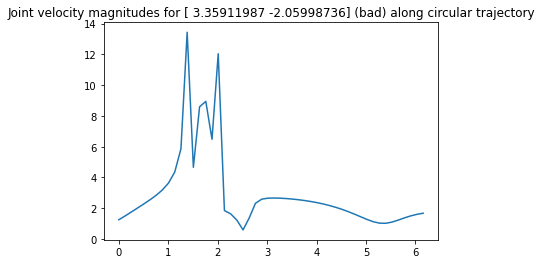

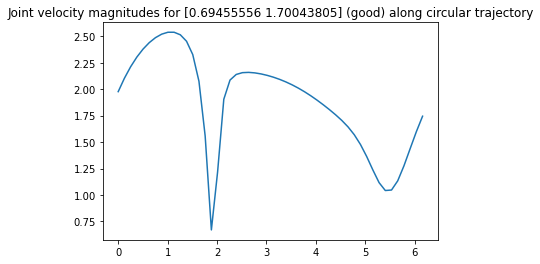

In [328]:
theta_bad = [math.pi/2, math.pi/2]
theta_good = [math.pi/4, math.pi/2]
delta = 0.05
radius = 1.25 #The radius of the circle we intended to draw
#Question: In order to make drawn circle be this radius, should I somehow relate delta to radius?

bad_theta_dot_list = []
good_theta_dot_list = []

cur_degree = 0 #this is the current degrees in the circle we are drawing, start at 0
start = cur_degree
end = 2*math.pi
step_size = (end-start)/50
for cur_degree in np.arange(start,end,step_size):
    #visualize_robot(theta=theta,show=False)
    #claculate the tangent to the circle at this degree. The tangent defines how we want the end effector tip to move
    x_dot = -math.sin(cur_degree)*radius
    y_dot = math.cos(cur_degree)*radius
    
    tau_dot = [x_dot,y_dot]
    
    J_bad = _J(theta=(theta_bad))
    J_good = _J(theta=(theta_good))

    J_inv_bad = np.linalg.inv(J_bad)
    J_inv_good = np.linalg.inv(J_good)

    theta_dot_bad = np.matmul(J_inv_bad, tau_dot)
    theta_dot_good = np.matmul(J_inv_good, tau_dot)
    
    bad_theta_dot_list.append(np.linalg.norm(theta_dot_bad))
    good_theta_dot_list.append(np.linalg.norm(theta_dot_good))
    
    theta_bad = theta_bad + theta_dot_bad * delta
    theta_good = theta_good + theta_dot_good * delta

plt.plot(np.arange(start,end,step_size),bad_theta_dot_list)
plt.title(f"Joint velocity magnitudes for {theta_bad} (bad) along circular trajectory")
plt.show()
plt.title(f"Joint velocity magnitudes for {theta_good} (good) along circular trajectory")
plt.plot(np.arange(start,end,step_size),good_theta_dot_list)
plt.show()

As we can see, the joint velocities get very high near the singularities. The robot may have to move to very different joint configurations near singularities, so they joint velocity magnitude can explode. This can be dangerous on a real robot since we are putting a lot of energy into the system, and the robot may behave very erradically.

## Manipulability Analysis

It'd be nice to visualize the column space of the Jacobian at the end-effector tip to get understanding of which directions the robot can move. The column space of the Jacobian can be represented many choices of basis functions, so which makes the most sense? One interesting choice is to look at the singular vectors. We call the ellipise whose major and minor axes are the singular vectors of the jacobian the manipulability ellipsoid. It tells us which directions it's easiest for the robot to move.

In [329]:
def visualize_manipulability_ellipsoid(theta=(0,0),show=True,colors=["black","gray"]):
    J = _J(theta=theta)
    
    link1, link2 = forward_kinematics(theta=theta)

    #do singular value decomposition
    u, s, vh = np.linalg.svd(J)
    print(u)
    print(s)

    if s[0] != 0:
        relative_u1 = [(u_*s[0]) + l_ for (u_,l_) in zip(u[0,:],link2)]
        plt.plot(*zip(link2,relative_u1), marker='o',linestyle="dashed",color=colors[0])
    
    if s[1] != 0:
        relative_u2 = [(u_*s[1]) + l_ for (u_,l_) in zip(u[1,:],link2)]
        plt.plot(*zip(link2,relative_u2), marker='o',linestyle="dashed",color=colors[1])
    

[[ 0.29404035 -0.95579301]
 [-0.95579301 -0.29404035]]
[1.29371446 0.7028579 ]


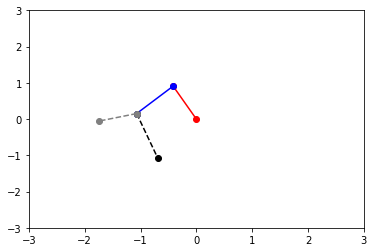

In [330]:
theta = [2,2]
visualize_robot(theta=theta,show=False)
visualize_manipulability_ellipsoid(theta=theta,show=False)

plt.show()

It turns out that the determinent of the jacobian is equal to the product of the singular values (or the eigen vectors when the jacobian is square). We call this the manipulablity index.

We can also get a better intuition for why trying to move the end-effector in a direction that is collapsing near a singularity results in large joint velocities. If we treat the singular vectors as a basis for the space of possible end-effector velocities, then we can describe the desired directions as a linear composition of the singular vectors. When considering the component of the intended direction that is projected onto the collapsing direction, the agent will need to have a high-magnitude joint velocity to compensate for the small associated signular value.

## Three Link Robot

Let's make a three link robot to see how it does!

In [331]:
import math

def forward_kinematics3(l1=1,l2=1,l3=1,theta=(0,0,0)):
    x1 = math.cos(theta[0])*l1
    y1= math.sin(theta[0])*l1
    
    x2 = x1 + math.cos(theta[1]+theta[0])*l2 
    y2 = y1 + math.sin(theta[1]+theta[0])*l2 
    
    x3 = x2 + math.cos(theta[2]+theta[1]+theta[0])*l3 
    y3 = y2 + math.sin(theta[2]+theta[1]+theta[0])*l3 
    
    return((x1,y1),(x2,y2),(x3,y3))
    
import matplotlib.pyplot as plt

def visualize_robot3(l1=1,l2=1,l3=1,theta=(0,0,0),show=True,print_link=False,colors=[[1,0,0],[0,1,0],[0,0,1]]):
    link1, link2, link3 = forward_kinematics3(l1,l2,l3,theta)
    if print_link:
        print(f"link1: {link1}, link2:{link2}, link3:{link3}")
    plt.plot(*zip((0,0),link1), marker='o',color=colors[0])
    plt.plot(*zip(link1,link2), marker='o',color=colors[1])
    plt.plot(*zip(link2,link3), marker='o',color=colors[2])
    
    plt.xlim([-(l1+l2+l3+1), l1+l2+l3+1])
    plt.ylim([-(l1+l2+l3+1), l1+l2+l3+1])
    if show:
        plt.show()

import numpy as np

#Jacbobian in this case is 2x3
def _J3(theta=[0,0],l1=1,l2=1,l3=1):
    dx_t0 = -math.sin(theta[0])*l1 - math.sin(theta[0]+theta[1])*l2 - math.sin(theta[0]+theta[1]+theta[2])*l3
    dx_t1 = - math.sin(theta[0]+theta[1])*l2 - math.sin(theta[0] + theta[1] + theta[2])*l3
    dx_t2 = -math.sin(theta[0] + theta[1] + theta[2])*l3
    dy_t0 = math.cos(theta[0])*l1 + math.cos(theta[0] + theta[1])*l2 + math.cos(theta[0]+theta[1]+theta[2])*l3
    dy_t1 = math.cos(theta[0] + theta[1])*l2 + math.cos(theta[0] + theta[1] + theta[2])*l3
    dy_t2 = math.cos(theta[0]+theta[1]+theta[2])*l3
    return(np.array([[dx_t0, dx_t1, dx_t2],[dy_t0, dy_t1, dy_t2]]))

link1: (1.0, 0.0), link2:(1.0, 1.0), link3:(0.29289321881345254, 1.7071067811865475)


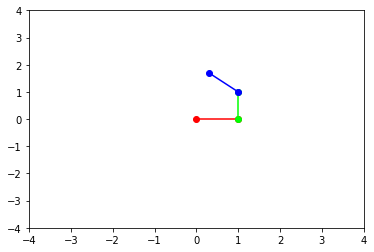

In [332]:
theta = [0,math.pi/2,math.pi/4]
visualize_robot3(theta=theta,print_link=True)
J = _J3(theta=theta)

## Rectangular Jacobians and where to find them

You may have realized that for a robot that has an task space dimension different than the configuration space dimension (e.g: controlling 2d position of robot end effector with a 3 joint arm like above), the Jacobian will be rectangular instead of square. In that case, we can't invert the matrix like normal, so we use the pseudo-inverse

In [333]:
theta = [0,math.pi/3,0.2]
J = _J3(theta=theta)
print(f"Jacoian is {J}")
J_inv = np.linalg.pinv(J) #pseudo inverse
print(f"Inverse of Jacobian is {J_inv}")

Jacoian is [[-1.81412262 -1.81412262 -0.94809722]
 [ 1.8179806   0.8179806   0.3179806 ]]
Inverse of Jacobian is [[ 0.39791911  0.94246216]
 [-0.69633157 -0.66787795]
 [-0.48375124 -0.52539911]]


In this case the number of joints in 3 and the number of task space dimensions is 2, so the Jacobian is a 2x3 matrix. It makes sense that the pseudo-inverse of the Jacobian would be a 3x2 matrix.

## Look Ma, even more circles!

Time for our favorite activity: drawing circles! This time, with a three-link robot using the pseudo-inverse!

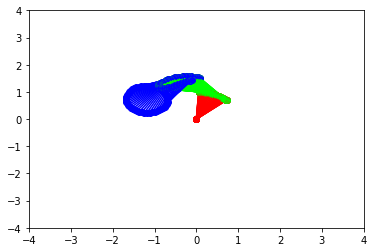

In [334]:
theta = [math.pi/4, math.pi/2, math.pi/2]
delta = 0.05
radius = 1.25 #The radius of the circle we intended to draw
#Question: In order to make drawn circle be this radius, should I somehow relate delta to radius?

cur_degree = 0 #this is the current degrees in the circle we are drawing, start at 0
for cur_degree in np.arange(0,2*math.pi,2*math.pi/50):
    visualize_robot3(theta=theta,show=False)
    #claculate the tangent to the circle at this degree. The tangent defines how we want the end effector tip to move
    x_dot = -math.sin(cur_degree)*radius
    y_dot = math.cos(cur_degree)*radius
    
    tau_dot = [x_dot,y_dot]
    
    J = _J3(theta=(theta))

    J_inv = np.linalg.pinv(J)

    theta_dot = np.matmul(J_inv, tau_dot)
    theta = theta + theta_dot * delta
    
plt.show()
    

In [336]:
#TODO: Look at manipulabiltiy ellipsoid for a specific direction

In [337]:
#TODO: other manipulability analysis components, like distance to joint configuration

In [29]:
#TODO inverting a rectangular Jacobian

In [30]:
#TODO: all the places I'm drawing with the robot should abstracted to single function

In [155]:
#TODO: include orientation in Jacobian

In [174]:
#TODO: section on inverse kinematics

In [ ]:
#TODO: Look at force ellipsoid

In [ ]:
#TODO: Look at jacobian transpose for end-effector wrench / joint torques

In [175]:
#TODO: Simulate gravity

In [335]:
#TODO: Hybrid position-force control